In [1]:

import stackstac
import satsearch
from datetime import datetime
import dask.diagnostics

import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
#import geojson
import json

from datetime import datetime

from shapely.geometry import mapping

#import zarr
import netCDF4

import os
import lxml


In [2]:
#!conda install netCDF4 --yes
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' #This is KEY! otherwise we send a bunch of HTTP GET requests to test for common sidecar metadata
os.environ['AWS_NO_SIGN_REQUEST']='YES' #Since this is a public bucket, we don't need authentication
os.environ['GDAL_MAX_RAW_BLOCK_CACHE_SIZE']='200000000'  #200MB: Want this to be greater than size of uncompressed raster to overcome a 10 MB limit in the GeoTIFF driver for range request merging.
os.environ['GDAL_SWATH_SIZE']='200000000'  #also increase this if increasing MAX_RAW_BLOCK_CACHE_SIZE
os.environ['VSI_CURL_CACHE_SIZE']='200000000' #also increase this if increasing MAX_RAW_BLOCK_CACHE_SIZE
# Others?

In [3]:
#!conda install lxml --yes
#!conda install -c conda-forge rtree=0.9.3 --yes  fixes geopandas lib spatial index dll error
filelisting_netcdf = 'https://s3-ap-southeast-2.amazonaws.com/silo-open-data/annual/index.html'

In [4]:
silo = pd.read_html('http://s3-ap-southeast-2.amazonaws.com/silo-open-data/annual/index.html')

In [5]:
silo

[Empty DataFrame
 Columns: [Name, Date Modified, Size, Type]
 Index: []]

In [6]:
oz = xr.open_rasterio(f'https://s3-ap-southeast-2.amazonaws.com/silo-open-data/annual/rh_tmax/2020.rh_tmax.nc', chunks=(1,1024,1024))

C:\Users\rnmsc\anaconda3\envs\stackstac\lib\site-packages\rasterio\__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
oz

<xarray.DataArray (band: 366, y: 681, x: 841)>
dask.array<open_rasterio-cafea85b44866a7ff7ff930a2b7aa2a9<this-array>, shape=(366, 681, 841), dtype=int16, chunksize=(1, 681, 841), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int32 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 676.5 677.5 678.5 679.5 680.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 836.5 837.5 838.5 839.5 840.5
Attributes:
    transform:   (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:         (1.0, -1.0)
    is_tiled:    0
    nodatavals:  (-32767.0, -32767.0, -32767.0, -32767.0, -32767.0, -32767.0,...
    scales:      (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
    offsets:     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [9]:
oz = oz.where(oz <= -32767.0, drop=True)

RasterioIOError: Read or write failed. HDF5:"/vsicurl/https://s3-ap-southeast-2.amazonaws.com/silo-open-data/annual/rh_tmax/2020.rh_tmax.nc"://rh_tmax, band 126: IReadBlock failed at X offset 0, Y offset 0: H5Dread() failed for block.

In [12]:
oz[0]

<xarray.DataArray (y: 681, x: 841)>
dask.array<getitem, shape=(681, 841), dtype=int16, chunksize=(681, 841), chunktype=numpy.ndarray>
Coordinates:
    band     int32 1
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 676.5 677.5 678.5 679.5 680.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 836.5 837.5 838.5 839.5 840.5
Attributes:
    transform:   (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:         (1.0, -1.0)
    is_tiled:    0
    nodatavals:  (-32767.0, -32767.0, -32767.0, -32767.0, -32767.0, -32767.0,...
    scales:      (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
    offsets:     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [17]:
oz[74].mean().compute()

<xarray.DataArray ()>
array(-16476.39626974)
Coordinates:
    band     int32 75

In [19]:
oz[200].mean().compute()

<xarray.DataArray ()>
array(-16456.9537768)
Coordinates:
    band     int32 201

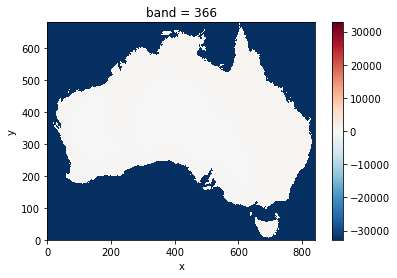

In [28]:
oz[365].plot(robust=True)

In [23]:
oz[200].shape

(681, 841)

In [ ]:
np.unique(oz[200].values, return_counts=True)

In [ ]:
oz.plot()

In [ ]:
oz.rio.to_raster(r'humid.tif')